# Stochastic Invasion of Variants of Concern

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd
import sympy as sym
from odeintw import odeintw

In [3]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew

In [4]:
# =============================================================================
# Safely invert a matrix (avoiding complex numbers)
# =====================================================================

def invert_mat_safe(A): # We don't use this any more but it's useful to have
    P, L, U = sp.linalg.lu(A.copy())
    I = np.identity(len(A.copy()))
    Psys = sp.linalg.solve(P, I)
    Lsys = sp.linalg.solve_triangular(L, Psys, lower = True)
    Usys = sp.linalg.solve_triangular(U, Lsys)
    return Usys




def Omega_sym(t):
    a, b, c, d, s, g, beta = sym.symbols('a b c d s g beta')
    Omat = sym.Matrix([[-s, 0, 0, 0, s, 0, 0, 0], 
                     [0, -s, 0, 0, 0, s, 0, 0], 
                     [0, 0, -s, 0, 0, 0, s, 0], 
                     [0, 0, 0, -s, 0, 0, 0, s],
                      [a*beta, b*beta, c*beta, d*beta, -g, 0, 0, 0],
                      [a*beta, b*beta, c*beta, d*beta, 0, -g, 0, 0],
                      [a*beta, b*beta, c*beta, d*beta, 0, 0, -g, 0],
                      [a*beta, b*beta, c*beta, d*beta, 0, 0, 0, -g]]
                     )
    return Omat


def eigvls_sym(params, offspring):
    evals = offspring(0).diagonalize()[1]
    return np.diag(np.array(evals.subs(params)).astype(np.float64))

def eigvects_sym(params, offspring, norm = True):
    evects = offspring(0).diagonalize()[0]
    evects = np.array(evects.subs(params)).astype(np.float64)
    if norm:
        for j in range(0, np.shape(evects)[1]):
            evects[:, j] /= np.sqrt(np.sum(evects[:, j]**2))
    return evects

def reorder_evecs(eigenvalues, eigenvectors, ordering):
    eigenvalues_new = np.asarray([eigenvalues[j] for j in ordering])
    eigenvectors_new = np.asarray([eigenvectors[:,j] for j in ordering]).T
    return eigenvalues_new, eigenvectors_new

In [5]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP:
    # Set offspring distribution for the process - this defines the process
    def __init__(self, offspring):
        self.offspring = offspring
        return None
    
    # Set lifetimes for particles of each type
    def set_lifespans(self, omega):
        self.omega = omega
        return None
    
    def set_rates(self, beta, gamma):
        self.beta = beta
        self.gamma = gamma
        return None
    
    def get_lifespans(self):
        return self.omega
    
    
    # Set a vector of immigration rates
    def set_immigration(self, eta):    
        self.eta = eta
    
    # Build ODEs for the probability of extinction of a process that begins with a single particle of each type, 
    # excluding immigration. The final equation includes immigration and describes the full process starting with a
    # vector of n0 particles of each type and immigration at rate eta. 
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
        method = methodclass(set_odes)
        method.set_ic(u0=ics)
        R, t = method.solver(time_points=t)
#         R = sp.integrate.odeint(set_odes, ics, time).T
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if type(n0) != np.ndarray:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol

    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if type(u) == float:
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = Omega(t)@u + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
        method = methodclass(set_mean_odes)
        method.set_ic(u0=ics)
        M, t = method.solver(time_points=t)
        return M
    
    def variance(self, t, param_dict, Omega_sym, n0vec):
        eta =  self.eta
        omega = self.omega(0)
        Omega = self.Omega
        ntypes = len(omega)
        
        nexposed = int(ntypes/2)
        beta, gamma = self.beta, self.gamma
        
        # Eigenvalues and Eigenvectors
        eigvls = eigvls_sym(param_dict, Omega_sym)
        orth = eigvects_sym(param_dict, Omega_sym)
        ordering = (np.argsort(eigvls)).tolist()
        eigvls, orth = reorder_evecs(eigvls, orth, ordering)
        diagmat = np.diag(eigvls)
        self.growth_rate = np.max(eigvls)
        
        orth_inv = invert_mat_safe(orth.copy())
        orth_c = orth.copy().T
        orthc_inv = invert_mat_safe(orth_c.copy())
        
        ### Build variance matrix via Kronecker Products
        H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
        Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c)) 
        Amat = np.kron(orthc_inv, orthc_inv)
        Amat_inv = np.kron(orth_c, orth_c)
        
        vec_w = np.zeros(ntypes**3)
        
        # Build Hessian matrix
        Hessian_mat = np.zeros((ntypes, ntypes, ntypes))
        

        for level in range(0, nexposed):
            for i in range(0, nexposed):

                Hessian_mat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega[level+nexposed])
                Hessian_mat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega[level+nexposed])


        
        
        P_mat = np.zeros((ntypes, ntypes))
        

        for nex in range(0, nexposed):
            P_mat[nex, nex+nexposed] = omega[nex]/omega[nex]
            P_mat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA/omega[nex+nexposed]
            P_mat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)/omega[nex+nexposed]
    
        P_mat = P_mat.T
        
        Gmat = np.zeros((ntypes, ntypes, ntypes))
        C = np.zeros(ntypes**3)
        
        for l in range(0, ntypes):

            Gmat[l, :, :] = Hessian_mat[l, :, :] + np.diag(P_mat[:, l]) - np.outer(P_mat[:, l], P_mat[:, l])
            unitvec = np.zeros(ntypes)
            unitvec[l] = 1
            Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(P_mat[:, l], P_mat[:, l]) - np.outer(unitvec, P_mat[:, l]) - np.outer(P_mat[:, l], unitvec)
            Gmat[l, :, :] *= omega[l]
            C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator
        
        HinvC = Hinv @ C
        
        # Build diagonal matrices for Kronecker Product
        
        kp = np.kron(diagmat, np.identity(ntypes)) + np.kron(np.identity(ntypes), diagmat) # Kronecker product
        kp_inv = nla.inv(kp)
        
        
        
        diagmat_inv = nla.inv(diagmat)
        idn = np.identity(ntypes)
        dkron = np.kron(-diagmat, np.identity(ntypes**2)) + np.kron(idn, kp)
        dkron_inv = nla.inv(dkron)
        
        var_vec = np.zeros((len(time)))
        var_mat = np.zeros((len(time), ntypes, ntypes))
        T_idx = 0
        for T in tqdm(t):
            vec_w = np.zeros(ntypes**3)
            vec_v = np.zeros(ntypes**3)
            
            integral_1 = np.kron(idn, (sp.linalg.expm(T*kp) - sp.linalg.expm(0*kp))@kp_inv)@dkron_inv
            integral_2 = np.kron((sp.linalg.expm(T*diagmat) - idn)@diagmat_inv, np.kron(idn, idn))@dkron_inv
            Dmat_im = integral_1 - integral_2
            Dmat = (sp.linalg.expm(kp*T) - sp.linalg.expm(kp*0))@kp_inv
            vecvar = H @ Dmat_im  @ HinvC
            sum_vecvar_i = np.zeros((ntypes, ntypes))
            for i in range(0, ntypes):
                
                unitvec = np.zeros(ntypes)
                unitvec[i] = 1.
                vecvar_i =  np.kron(unitvec, np.kron(np.identity(ntypes), np.identity(ntypes))) @ vecvar
                sum_vecvar_i += n0vec[i] * np.reshape(vecvar_i, (ntypes, ntypes)).transpose()
                unit_outer_prod = np.outer(unitvec, unitvec).flatten() # Stack columns for 'vec' operator
                vec_wi =  im_vec[i] * (Amat @ Dmat @ Amat_inv @ unit_outer_prod)
                
                vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
                vec_v[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = im_vec[i] * vecvar_i
                
            v = np.reshape(vec_v, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
            w = np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)

            v += w
            v += sum_vecvar_i
            
            var_vec[T_idx] = np.sum(v)
            var_mat[T_idx, :, :] = np.sum(v, axis = 0)
            T_idx +=1
            
        self.var_vec = var_vec
        self.var_mat = var_mat
        return var_vec
    
    def get_var_mat(self):
        try:
            return self.var_mat
        except:
            print("Error - must first run MTBP.variance() to obtain var_mat.") 
    def Tstar(self, t, p_zero, var_coeff, thresh1=1e-2, thresh2=1e-2):
        dt = t[1] - t[0]
        diff_pzero = np.abs(np.gradient(p_zero, dt))
        try:
            T1_idx = int(np.min(np.where(diff_pzero<=thresh1)[0]))
        except:
            raise ValueError("Try higher value of thresh1")
        
        diff = diff = np.abs(np.gradient(var_coeff, dt))
        try:
            T2_idx = int(np.min(np.where(diff<=thresh2)[0])) 
        except:
            raise ValueError("Try higher value of thresh2")
        Tstar_idx = int(np.max((T1_idx, T2_idx)))
        Tstar = t[Tstar_idx]
        return [Tstar_idx, Tstar]
    
    def get_growth_rate(self):
        return self.growth_rate
        
    


In [6]:
# Parameters to change 

ntypes = 8
nexposed = int(ntypes/2)

# Disease Parameters
# Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype 
Reff_vec = np.array((2., 2.5, 3., 3.5, 4.))
rtrans_variant = 1. # Relative transmissability of SA variant compared to wildtype
gamma = 1/7 # Recovery Rate
sigma = 1/3 # Progression rate from exposed to infectious

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
vac_uk = 1-0.7 # Reduction in transmission of UK variant due to vaccine
vac_sa = 1-0.6 # Reduction in transmission of SA variant due to vaccine
# vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

#k = -1 #1/10 # Dispersion Endo et al.

Tmax = 1200 
num = 2*Tmax + 1
time = np.linspace(0, Tmax, num=num)
# time = np.arange(Tmax)
# Reduced transmissability for each type based on infection/vaccine immunity

const_vec = np.array((1., sus_sa, vac_sa, np.min((vac_sa, sus_sa))))





p_vac = 0.7
# p_new = 0 # % vaccinated with putative new vaccine (currently 0) 
p_no_vac = 1- p_vac #0.32 -0.17#p_vac #p_az - p_pf #- p_new # % unvaccinated

p_rec = 0.2 # % recovered from previous strains
p_sus = 1-p_rec # % never infected with any coronavirus


prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_vac, p_rec*p_vac))
scale = const_vec*prop_vec

save = 0

# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

im_switch = 0

if im_switch:
    im = 0.1 # Baseline 0.2, also try 0.1, 1/3
    im_vec = np.zeros(ntypes)
    im_vec[:nexposed] = im*prop_vec*const_vec # Rate of importation for unvaccinated exposed cases of variants with no previous infection history
    n0vec = np.zeros(ntypes)
    n0vec[0] = 0
else:
    im = 0
    im_vec = np.zeros(ntypes)
    im_vec[:nexposed] = im*prop_vec*const_vec # Rate of importation for unvaccinated exposed cases of variants with no previous infection history
    n0vec = np.zeros(ntypes)
    n0vec[0] = 1

ics = [0 for n0 in range(len(n0vec))]
ics.append(int(all(n0vec==0)))
ics = np.array(ics)
# ics = np.ones(ntypes + 1)



In [7]:
save

0

In [8]:
prop_vec*const_vec
Reff_vec
im_vec


array([0., 0., 0., 0., 0., 0., 0., 0.])

100%|███████████████████████████████████████| 2401/2401 [00:45<00:00, 52.90it/s]
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/2708331021.py:150: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(variance[r, :]), label = str(RV))
100%|███████████████████████████████████████| 2401/2401 [00:43<00:00, 55.46it/s]
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/2708331021.py:150: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(variance[r, :]), label = str(RV))
100%|███████████████████████████████████████| 2401/2401 [00:41<00:00, 58.05it/s]
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/2708331021.py:150: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(variance[r, :]), label = str(RV))
100%|███████████████████████████████████████| 2401/2401 [00:39<00:00, 61.48it/s]
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/2708331021.py:150: RuntimeWarning: divi

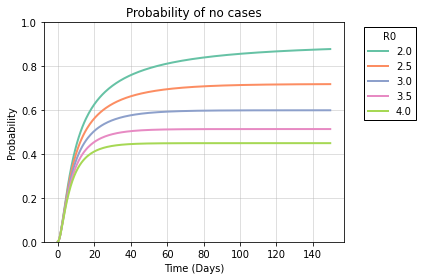

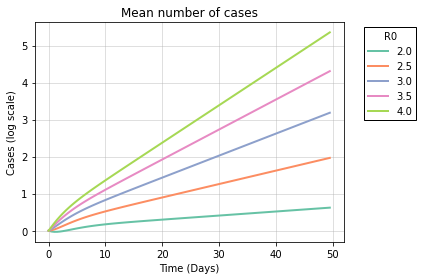

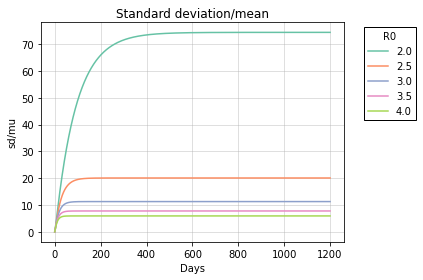

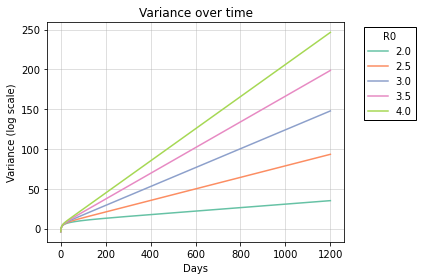

In [9]:
# Solve ODEs 

# Initialise Probability of Zero
rho_mat = np.zeros((len(Reff_vec), len(time)))
q_mat = np.zeros_like(rho_mat)
R_vec = np.zeros_like(Reff_vec)
cmp = plt.cm.get_cmap('Set2')
sns.set_palette("Set2")

# Initialise Mean
mean = np.zeros((len(Reff_vec), len(time)))
plot_log = 1

mean_arr = np.zeros((len(Reff_vec), ntypes, len(time)))
    
# Initialise Variance
variance = np.zeros((len(Reff_vec), len(time)))
lamb_vec = np.zeros(len(Reff_vec)) # Vector of growth rates for each R0
var_mat = np.zeros((len(Reff_vec), len(time), ntypes, ntypes))

# Initialise Tstar
Tstar_idxs = np.zeros(len(Reff_vec))
Tstars = np.zeros(len(Reff_vec))
epsilon = 1e-4

# Plotting Parameters
showplot = 100
showplot_rho = 300

R_effective_vec = np.zeros(len(Reff_vec))





for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant

    RV = Reff*rtrans_variant

    
    omega_vec = sigma * np.ones(ntypes) 

    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
    def omega(t): # Return vector of lifetimes for each state
        return omega_vec

    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_SA) + gamma)
        

        sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[:nexposed])
         
        for nex in range(0, nexposed):

            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs + (gamma/omega)
        
        return pvec            
            
            
    def eta(t):
        return im_vec.astype(float)
    


    
    offspring = P
    outbreak = MTBP(offspring)
    outbreak.set_lifespans(omega)
    outbreak.set_immigration(eta)
    outbreak.set_rates(beta_SA, gamma)
    rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = False) # Solve ODEs for probabilities of extinction/zero
    q_mat [r, :] = rho[0, :]
    rho_mat[r, :] = rho[-1, :] # Take 0th row for qs, -1th row for rs

    
    
    
    # Mean curve
    def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
        Omat = np.zeros((ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)       

        for nex in range(0, nexposed):
            omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
            Omat[nex, nex+nexposed] = omega_vec[nex]
            Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
            Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

        Omat -= np.diag(omega_vec)

        return Omat
    
    outbreak.set_Omega(Omega)
    n0s = n0vec

#     Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s, methodclass=RungeKutta4)

    Mvec = sp.integrate.odeint(outbreak.set_mean_odes, n0s, time).T
    mean_arr[r, :, :] = Mvec

    mean[r, :] = np.sum(Mvec, axis=0)
    
    # Variance + Coefficient of Variation
    param_dict = {"a":scale[0], "b":scale[1], "c":scale[2], "d":scale[3], "s":sigma, "g":gamma, "beta":beta_SA}
    
    
    variance[r, :] = outbreak.variance(time, param_dict, Omega_sym, n0vec)
    var_mat[r, :, :, :] = outbreak.get_var_mat()
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    sig_over_mean = (np.sqrt(variance[r, :])/(mean[r, :]))
    Tstar = outbreak.Tstar(time, rho_mat[r, :], sig_over_mean, thresh1 = epsilon, thresh2 = epsilon)
    Tstar_idxs[r] = Tstar[0]
    Tstars[r] = Tstar[1]
    lamb_vec[r] = outbreak.get_growth_rate()
    
    #Calculate Eigenvalues of Next Generation Matrix
    
    Sigma_mat = Omega(0)
    Sigma_mat[nexposed:, :nexposed] = 0
    T_mat = Omega(0) - Sigma_mat
    next_gen = - T_mat @ nla.inv(Sigma_mat)
    R_effective = np.max(nla.eigvals(next_gen))
    R_effective_vec[r] = R_effective
    
    
    # Plot figures
    plt.figure(1)
    if im==0:
        plt.plot(time[:showplot_rho], q_mat[r, :showplot_rho], lw=2, label = str(np.round(RV, 2)))
    else:
        plt.plot(time[:showplot_rho], rho_mat[r, :showplot_rho], lw=2, label = str(np.round(RV, 2)))
    
    plt.figure(2)
    if plot_log:
        plt.plot(time[:showplot], np.log(mean[r, :showplot]), lw = 2, label = str(np.round(RV, 2)))
    else:
        plt.plot(time[:showplot], mean[r, :showplot], lw = 2, label = str(np.round(RV, 2)))
        
    plt.figure(3)
    plt.plot(time, sig_over_mean , label = str(RV))
    plt.figure(4)
    plt.plot(time, np.log(variance[r, :]), label = str(RV))
        

        
# Tidy up plots
plt.figure(1)
plt.grid(alpha = 0.5)
plt.title("Probability of no cases" )
plt.xlabel("Time (Days)")
plt.ylabel("Probability")
plt.ylim([0, 1])
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./pnocases_im=" + str(im) + "_n0=0.pdf")
    
plt.figure(2)
plt.grid(alpha = 0.5)
if plot_log:
    plt.title("Mean number of cases" )
    plt.ylabel("Cases (log scale)")
else:
    plt.title("Mean number of cases" )
    plt.ylabel("Cases")
    
plt.xlabel("Time (Days)")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./meancases_im=" + str(im) + "plotlog=" + str(plot_log) + "_n0=0.pdf")

plt.figure(3)
plt.grid(alpha = 0.5)
plt.title("Standard deviation/mean")
plt.ylabel("sd/mu")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./sd_over_mean_plot_im=" + str(im) + ".pdf")

plt.figure(4)
plt.grid(alpha = 0.5)
plt.title("Variance over time")
plt.ylabel("Variance (log scale)")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./variance_plot_im=" + str(im) + ".pdf")
    
    
Tstar_idxs = Tstar_idxs.astype(int)


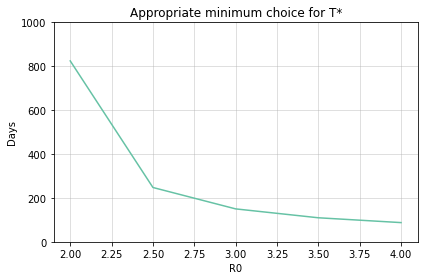

In [10]:
Tstar_idxs = Tstar_idxs.astype(int)

plt.figure()
plt.grid(alpha = 0.5)
plt.plot(Reff_vec*rtrans_variant, Tstars)
plt.title("Appropriate minimum choice for T*")
plt.xlabel("R0")
plt.ylabel("Days")
if im_switch:
    plt.ylim([0, 300])
else:    
    plt.ylim([0, 1000])

plt.tight_layout()

if save:
    plt.savefig("./tstarchoice_im=" + str(im) + ".pdf")

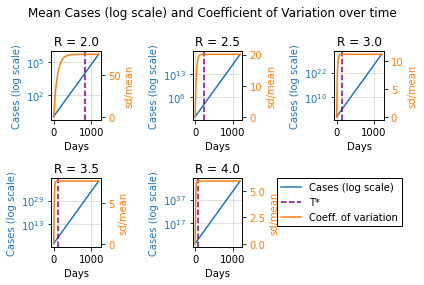

In [11]:

Istars_min = np.zeros(len(Reff_vec))
for r in range(0, len(Reff_vec)):
    Istars_min[r] = mean[r, Tstar_idxs[r]]
    
#     tst_idx[r] = np.min(np.where(mean[r, :]>=threshold))
if not im_switch: 
    showplot = -1
else:
    showplot = 1400

fig, axs = plt.subplots(2, 3)
for r in range(0, len(Reff_vec)):
    sig_vec = np.sqrt(variance)
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    if r<=2:
        b = 0
    else:
        b=1    
    color = 'tab:blue'
    if r ==0:
        
        axs[b, r%3].plot(time[:showplot], mean[r, :showplot] , color = color, label = "Cases (log scale)")
    else:
        axs[b, r%3].plot(time[:showplot], mean[r, :showplot] , color = color)
        axs[b, r%3].axvline(time[Tstar_idxs[r]], color = 'purple', linestyle = '--')
    axs[b, r%3].tick_params(axis='y', labelcolor=color)
    axs[b, r%3].grid(alpha = 0.5)
    axs[b, r%3].set_ylabel("Cases (log scale)", color = color)
    axs[b, r%3].set_ylabel("Cases (log scale)", color = color)
    axs[b, r%3].set_xlabel("Days")
    axs[b, r%3].set_yscale("log")
    axs[b, r%3].set_title("R = " + str(RV))
    axs[-1, -1].set_visible(False)
    color= 'tab:orange'
    ax1 = axs[b, r%3].twinx()
    if r ==0:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color, label = "Coeff. of variation")
        axs[b, r%3].axvline(time[Tstar_idxs[r]], color = 'purple', linestyle = '--', label = str("T*"))

    else:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("sd/mean", color = color)
    
    
    
bottom_right_ax = axs[-1][-1] 
bottom_right_ax.clear()  
bottom_right_ax.set_axis_off()
plt.suptitle("Mean Cases (log scale) and Coefficient of Variation over time")
fig.legend(loc='lower right', bbox_to_anchor=(0.95, 0.2),framealpha=1., edgecolor='black', fancybox=False)
fig.tight_layout()
if save:
    plt.savefig("sig_over_mean_plot_im=" + str(im) + ".pdf")

In [429]:
num_sims = 100000
G_test = np.zeros((3, num_sims))

class Gillespie:
    def __init__(self, rates, transitions, y0):
        
        assert(len(rates(y0)) == len(transitions))
        
        self.rates = rates
        self.y0 = y0
        self.numvars = len(y0)
        self.transitions = transitions
        return None
    
    
    def Gillespie_trajectory(self, Zstar = None, Tstar = None, max_events = int(1e7)):
        rates = self.rates
        y0 = self.y0
        numvars = self.numvars
        transitions = self.transitions
        output_mat = np.zeros((numvars+1, max_events))
        output_mat[1:, 0] = y0
        rands = np.random.random(size = (2, max_events))
        t = 0
        hitting_time = None
        case_check = 0
        for i in range(1, max_events):
            
            # Calculate rates
            
            rate_vec = rates(output_mat[1:, i-1])
            rate_cumsum = np.cumsum(rate_vec)
            rate_sum = np.sum(rate_vec)
            dt = -np.log(rands[0, i-1])/rate_sum
            
            # Update
            
            t += dt
            output_mat[0, i] = t
            choose_rand_event = rate_sum * rands[1, i-1]
            event_index = np.where(rate_cumsum > choose_rand_event)[0][0]
            
            output_mat[1:, i] = output_mat[1:, i-1] + transitions[event_index]

            total_infectious = np.sum(output_mat[1:, i])
            if Zstar is not None:
                if isinstance(Zstar, int) or isinstance(Zstar, float):
                    if total_infectious > Zstar:

                        hitting_time = t

                        return hitting_time

            
            if Tstar is not None:
                if t > Tstar:
                    check_cases = output_mat[1:, i]
                    return check_cases
                    
            if total_infectious == 0:
                break
            
        if Zstar is not None:
            return None
        elif Tstar is not None:
            return None
        else:
            return output_mat


In [430]:

for idx in [0, 2, 4]:# Choose index of Istars_min (Z^*) to obtain FPT distribution - improve by doing this for all!! 
    im_gillespie = im
    Reff = Reff_vec[idx]
    beta_SA = Reff*gamma


    def rates(u):           
        rates_vec = np.zeros(3*nexposed)
        rates_vec[:nexposed] = sigma*np.ones(nexposed)*u[:nexposed]
        rates_vec[nexposed:(2*nexposed)] = np.sum(const_vec*prop_vec*beta_SA*u[nexposed:]) + im_gillespie*prop_vec*const_vec
        rates_vec[(2*nexposed):(3*nexposed)] = gamma*u[nexposed:]
        return rates_vec

    transitions = {}
    for i in range(nexposed):
        exposed_to_infectious_trans = np.zeros(ntypes) #E_i -> I_i
        exposed_to_infectious_trans[i] = -1
        exposed_to_infectious_trans[i+nexposed] = 1

        transitions[i] = exposed_to_infectious_trans

        infection_trans = np.zeros(ntypes)
        infection_trans[i] = 1

        transitions[i+nexposed] = infection_trans

        recovery_trans = np.zeros(ntypes)
        recovery_trans[i+nexposed] = -1

        transitions[i + 2*nexposed] = recovery_trans


    y0vec = np.zeros(ntypes)
    if im_gillespie == 0:
        y0vec[0] = 1
    G = Gillespie(rates, transitions, y0vec)
    Reff_cols = [str(Re) for Re in Reff_vec]
    for i in tqdm(range(num_sims)):
        G_test[idx, i] = G.Gillespie_trajectory(Zstar = Istars_min[0])





  0%|                                                | 0/100000 [00:00<?, ?it/s]


IndexError: index 4 is out of bounds for axis 0 with size 3

In [433]:
G_df = pd.DataFrame(G_test)
G_df.to_csv("Gillespie_times.csv")
G_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635.791751,NaN,...,930.337634,NaN,NaN,517.323096,NaN,NaN,NaN,671.211579,NaN,NaN
1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,161.077756,126.887818,NaN,NaN,117.872467,NaN,NaN,NaN,121.481271,NaN,...,NaN,197.752919,149.943387,NaN,130.506604,NaN,NaN,NaN,NaN,NaN


In [434]:
idx = 4
im_gillespie = im
Reff = Reff_vec[idx]
beta_SA = Reff*gamma


def rates(u):           
    rates_vec = np.zeros(3*nexposed)
    rates_vec[:nexposed] = sigma*np.ones(nexposed)*u[:nexposed]
    rates_vec[nexposed:(2*nexposed)] = np.sum(const_vec*prop_vec*beta_SA*u[nexposed:]) + im_gillespie*prop_vec*const_vec
    rates_vec[(2*nexposed):(3*nexposed)] = gamma*u[nexposed:]
    return rates_vec

transitions = {}
for i in range(nexposed):
    exposed_to_infectious_trans = np.zeros(ntypes) #E_i -> I_i
    exposed_to_infectious_trans[i] = -1
    exposed_to_infectious_trans[i+nexposed] = 1

    transitions[i] = exposed_to_infectious_trans

    infection_trans = np.zeros(ntypes)
    infection_trans[i] = 1

    transitions[i+nexposed] = infection_trans

    recovery_trans = np.zeros(ntypes)
    recovery_trans[i+nexposed] = -1

    transitions[i + 2*nexposed] = recovery_trans


y0vec = np.zeros(ntypes)
if im_gillespie == 0:
    y0vec[0] = 1
G = Gillespie(rates, transitions, y0vec)
Reff_cols = [str(Re) for Re in Reff_vec]
for i in tqdm(range(num_sims)):
    G_test[1, i] = G.Gillespie_trajectory(Zstar = Istars_min[0])


100%|████████████████████████████████| 100000/100000 [27:41:21<00:00,  1.00it/s]


In [435]:
G_df = pd.DataFrame(G_test)
G_df.to_csv("Gillespie_times.csv")
G_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635.791751,NaN,...,930.337634,NaN,NaN,517.323096,NaN,NaN,NaN,671.211579,NaN,NaN
1,98.839346,NaN,NaN,NaN,89.727439,105.612044,100.870006,76.994402,NaN,83.574502,...,NaN,123.355760,73.717991,82.179403,NaN,96.062209,NaN,NaN,NaN,NaN
2,161.077756,126.887818,NaN,NaN,117.872467,NaN,NaN,NaN,121.481271,NaN,...,NaN,197.752919,149.943387,NaN,130.506604,NaN,NaN,NaN,NaN,NaN


In [436]:
G_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635.791751,NaN,...,930.337634,NaN,NaN,517.323096,NaN,NaN,NaN,671.211579,NaN,NaN
1,98.839346,NaN,NaN,NaN,89.727439,105.612044,100.870006,76.994402,NaN,83.574502,...,NaN,123.355760,73.717991,82.179403,NaN,96.062209,NaN,NaN,NaN,NaN
2,161.077756,126.887818,NaN,NaN,117.872467,NaN,NaN,NaN,121.481271,NaN,...,NaN,197.752919,149.943387,NaN,130.506604,NaN,NaN,NaN,NaN,NaN


In [542]:
idx = 2
im_gillespie = im
Reff = Reff_vec[idx]
beta_SA = Reff*gamma

omega_vec = sigma * np.ones(ntypes) 
for nex in range(0, nexposed):
    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
       
def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)       

    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        Omat[nex, nex+nexposed] = omega_vec[nex]
        Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

    Omat -= np.diag(omega_vec)

    return Omat
omega_vec   

array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.38114286,
       0.38114286, 0.38114286, 0.38114286])

In [545]:
eigvls = eigvls_sym(param_dict, Omega_sym)
orth = eigvects_sym(param_dict, Omega_sym)
ordering = (np.argsort(eigvls)).tolist()
eigvls, orth = reorder_evecs(eigvls, orth, ordering)
growth_rate = np.max(eigvls)

change_from_ebasis = -orth # P - ensure eigenvectors are positive
evec = change_from_ebasis[:, 0]
change_to_ebasis = invert_mat_safe(change_from_ebasis)
xi = change_to_ebasis[:, 0]
variance_diffusion_mat = np.zeros((ntypes, ntypes))
bingo = np.zeros((ntypes, ntypes))
for l in range(ntypes):
    variance_diffusion_mat += change_from_ebasis@(change_from_ebasis)@(Gmat[l, :, :] * xi[l])



# print(variance_all)
variance_all = nla.norm(variance_diffusion_mat[0,:])
evec_scaling = 1/np.sum(xi)

print(variance_all)





0.23108063199211476


In [546]:
# 1/evec_scaling
evec_scaling

0.5941001231089414

In [547]:

def feller_mu(u, t):
    return growth_rate * u  + np.sum(change_from_ebasis[:, 0]*im_vec)

def dW(t):
    return np.random.normal(loc = 0.0, scale = np.sqrt(t))

def feller_sigma(u, t):
    return ((variance_all*u))

def EulerMaruyama(drift, sigma, dW, t0, y0, dt, stop = None, num_its = len(time)):
    t = t0
    y = np.zeros(num_its)
    y[0] = y0
    stop_times = []
    checks = 0
    for i in range(1, num_its):
        yn = y[i-1] + drift(y[i-1], t)*dt + sigma(y[i-1],t) * dW(dt)
        if yn >0:
            y[i] = yn
        else:
            y[i] = 0
            stop_times = [np.nan for i in range(len(stop))]
            break
        
        if stop is not None:
            if yn >= stop[checks]:
                y[i:] = yn
                stop_time = t - dt
                stop_times.append(stop_time)
                checks +=1
                if checks == len(stop):
                    break
            
            
        
        t += dt
    if stop is not None:       
        if len(stop_times)<len(stop):
            stop_times_append = len(stop) - len(stop_times)
            stop_times_nans = [np.nan for i in range(stop_times_append)]
            stop_times += stop_times_nans
        
    return stop_times, y




y0 = 1
t0 = 0
dt = np.diff(time)[0]

# stop_cases = [50, int(Istars_min[-1])]
stop_cases = [50, int(Istars_min[idx])]
cols = [str(st) for st in stop_cases]


def chi_sq(u, x, t):
    x_scale = 2*growth_rate*x/(((variance_all/2))*(np.exp(growth_rate*t) - 1))
    lamb = 2*growth_rate*np.exp(growth_rate*t)/((variance_all/2)*(np.exp(growth_rate*t) - 1))
    chi_sq_pdf = growth_rate/((variance_all/2)*(np.exp(growth_rate*t) - 1)) * np.sqrt(np.exp(growth_rate*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
    return chi_sq_pdf


xvec = np.linspace(np.finfo(float).eps, 20000, int(1e5))
cdf_chisq = np.zeros_like(time)
xvec_idx = np.min(np.where(xvec>=(evec_scaling*Istars_min[idx]))[0])
# xvec_idx = np.min(np.where(xvec>=blorg)[0])


for T_idx, T_val in enumerate(tqdm(time)):
    chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T_val,)).flatten() 
    prob =  (1-(chi_sq_integral[xvec_idx]))
    cdf_chisq[T_idx] = prob
    
pdf_chisq = np.gradient(cdf_chisq, dt)




  0%|                                                  | 0/2401 [00:00<?, ?it/s]/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/1804711450.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  x_scale = 2*growth_rate*x/(((variance_all/2))*(np.exp(growth_rate*t) - 1))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/1804711450.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  lamb = 2*growth_rate*np.exp(growth_rate*t)/((variance_all/2)*(np.exp(growth_rate*t) - 1))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/1804711450.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  chi_sq_pdf = growth_rate/((variance_all/2)*(np.exp(growth_rate*t) - 1)) * np.sqrt(np.exp(growth_rate*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/1804711450.py:60: RuntimeWarning: invalid value 

/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_1107/260748752.py:1: RuntimeWarning: divide by zero encountered in true_divide
  lamb = 4*growth_rate*np.exp(growth_rate*time)/((variance_all)*(np.exp(growth_rate*time) - 1))


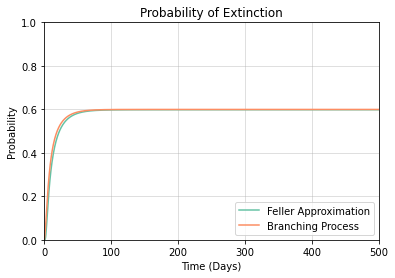

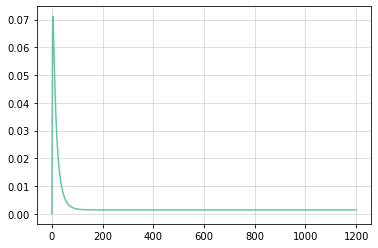

In [548]:
lamb = 4*growth_rate*np.exp(growth_rate*time)/((variance_all)*(np.exp(growth_rate*time) - 1))
plt.grid(alpha = 0.5)
plt.plot(time, np.exp(-lamb/2), label = "Feller Approximation")
# plt.plot(time, )

plt.plot(time, q_mat[idx, :], label = "Branching Process")
plt.title("Probability of Extinction")
plt.xlabel("Time (Days)")
plt.ylabel("Probability")
plt.ylim([0, 1])
plt.xlim([0, 500])
plt.legend(loc = "lower right")
plt.savefig("pextinct_comparison_R=" + str(Reff) + ".png")
plt.figure()
plt.grid(alpha = 0.5)
plt.plot(time, np.abs(np.exp(-lamb/2) - q_mat[idx, :]))


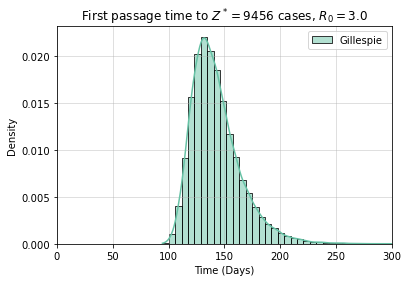

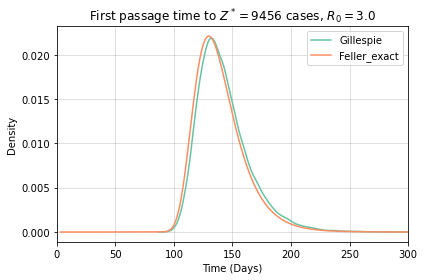

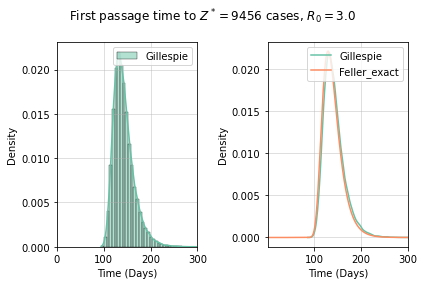

In [549]:

save = 1
plt.figure(11)
plt.grid(alpha = 0.5)
sns.histplot(G_test[-1, :], stat = 'density', kde = True, bins = 40, label = 'Gillespie', 
             alpha =0.5)  
# plt.plot(time, pdf_chisq, label = "Feller_exact", color = cmp(1))
plt.xlim([0, 300])
plt.xlabel("Time (Days)")
plt.title("First passage time to " + r'$Z^* = $' + str(int(Istars_min[idx])) + " cases, " + r"$R_0 = $" + str(Reff))
plt.legend()
if save:
    plt.savefig("FPT_gillespie_im=" + str(im) + "_R=" + str(Reff) + "Z=" + str(int(Istars_min[idx]))  + ".pdf")

plt.figure(27)
plt.grid(alpha = 0.5)
# sns.kdeplot(stop_times_df[cols[idx]],  label = 'Feller')
sns.kdeplot(G_test[-1, :], label = 'Gillespie') 
plt.plot(time, pdf_chisq, label = "Feller_exact")
plt.title("First passage time to " + r'$Z^* = $' + str(int(Istars_min[idx])) + " cases, " + r"$R_0 = $" + str(Reff))
plt.xlim([0, 300])
plt.xlabel("Time (Days)")
plt.legend()
plt.tight_layout()
if save:
    plt.savefig("FPT_both_im=" + str(im) + "_R=" + str(Reff) + "Z=" + str(int(Istars_min[idx]))  + ".pdf")

fig, axs = plt.subplots(1, 2)
axs[0].grid(alpha = 0.5)
sns.histplot(G_test[-1, :], stat = 'density', kde = True, bins = 40, label = 'Gillespie', 
             ax = axs[0])
axs[0].set_xlim([0, 300])
axs[0].set_xlabel("Time (Days)")
axs[0].legend()

axs[1].grid(alpha = 0.5)

sns.kdeplot(G_test[-1, :], label = 'Gillespie', ax = axs[1]) 
axs[1].plot(time, pdf_chisq, label = "Feller_exact")
axs[1].set_xlim([1, 300])       
axs[1].set_xlabel("Time (Days)")
axs[1].legend(loc = "upper right")

fig.suptitle("First passage time to " + r'$Z^* = $' + str(int(Istars_min[idx])) + " cases, " + r"$R_0 = $" + str(Reff)) 
fig.tight_layout()


In [337]:
lamb_vec
KS_dist = np.max(np.abs(sp.stats.gaussian_kde(G_test[~np.isnan(G_test)])(time[400:]) - pdf_chisq[400:]))
KL_div = sp.stats.entropy(pdf_chisq[400:], sp.stats.gaussian_kde(G_test[~np.isnan(G_test)])(time[400:]))
KS_dist


array([         nan, 128.77871825,          nan, 163.37829785,
       140.55121007,          nan,          nan, 147.13421906,
                nan,          nan,          nan,          nan,
       154.14540569,          nan, 190.25270797, 200.03204737,
       136.44545958, 178.59873653,          nan, 164.70068088,
       137.10693962,          nan, 140.5413534 , 117.69449556,
                nan,          nan,          nan, 114.95315775,
       132.86820068,          nan, 129.21615728, 117.95797559,
                nan, 123.48509908,          nan, 131.74053446,
       124.42691811, 134.29671135,          nan, 132.06217187,
                nan, 202.35171073,          nan, 145.22628532,
       146.67749211,          nan, 175.70101576,          nan,
                nan,          nan, 161.68503615,          nan,
                nan,          nan, 159.80759028, 149.96081426,
                nan, 138.57664589,          nan,          nan,
       132.8074988 ,          nan,          nan,       

In [324]:
# Istars_min
Tstars
# mean[0, Tstar_idxs[0]]

array([824.5, 247.5, 150. , 109.5,  87.5])

In [24]:
R_effective_vec

array([1.112, 1.39 , 1.668, 1.946, 2.224])

In [880]:
nla.norm(blorg@xi)

0.9886926851916384

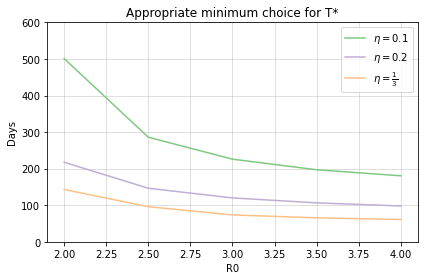

In [550]:
## Manually coded :(

Tstar_im_low = np.array((501, 286, 226, 197, 180.5))
Tstar_im_mid = np.array((217.5, 146.5, 120, 106.5, 98))
Tstar_im_high = np.array((143, 96, 73.5, 65.5, 61))
cmap = sns.color_palette("Accent")
save = 1

plt.figure()
plt.grid(alpha = 0.5)
plt.plot(Reff_vec*rtrans_variant, Tstar_im_low, label = r'$\eta = 0.1$', color = cmap[0])
plt.plot(Reff_vec*rtrans_variant, Tstar_im_mid, label = r'$\eta = 0.2$', color = cmap[1])
plt.plot(Reff_vec*rtrans_variant, Tstar_im_high, label = r'$\eta = \frac{1}{3}$', color = cmap[2])
plt.title("Appropriate minimum choice for T*")
plt.xlabel("R0")
plt.ylabel("Days")
plt.ylim([0, 600])
plt.legend()
plt.tight_layout()

if save:
    plt.savefig("./tstarchoice_im=" + 'all' + ".pdf")



In [543]:
eta =  eta


ntypes = len(omega_vec)

nexposed = int(ntypes/2)
beta = beta_SA

# Eigenvalues and Eigenvectors

param_dict = {"a":scale[0], "b":scale[1], "c":scale[2], "d":scale[3], "s":sigma, 
              "g":gamma, "beta":beta_SA}
    
eigvls = eigvls_sym(param_dict, Omega_sym)
orth = eigvects_sym(param_dict, Omega_sym)
ordering = (np.argsort(eigvls)).tolist()
eigvls, orth = reorder_evecs(eigvls, orth, ordering)
diagmat = np.diag(eigvls)
growth_rate = np.max(eigvls)

orth_inv = invert_mat_safe(orth.copy())
orth_c = orth.copy().T
orthc_inv = invert_mat_safe(orth_c.copy())

### Build variance matrix via Kronecker Products
H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c)) 
Amat = np.kron(orthc_inv, orthc_inv)
Amat_inv = np.kron(orth_c, orth_c)

vec_w = np.zeros(ntypes**3)

# Build Hessian matrix
Hessian_mat = np.zeros((ntypes, ntypes, ntypes))
for level in range(0, nexposed):
    for i in range(0, nexposed):

        Hessian_mat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
        Hessian_mat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])

P_mat = np.zeros((ntypes, ntypes))


for nex in range(0, nexposed):
    P_mat[nex, nex+nexposed] = omega_vec[nex]/omega_vec[nex]
    P_mat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA/omega_vec[nex+nexposed]
    P_mat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)/omega_vec[nex+nexposed]

P_mat = P_mat.T

Gmat = np.zeros((ntypes, ntypes, ntypes))
C = np.zeros(ntypes**3)
blorg = np.zeros((ntypes, ntypes))
for l in range(0, ntypes):
    f_vec = (P_mat - np.identity(ntypes))[l, :]
    unitvec = np.zeros(ntypes)
    unitvec[l] = 1

    Gmat[l, :, :] = Hessian_mat[l, :, :] - np.diag(P_mat[:, l]) #- np.outer(P_mat[:, l], P_mat[:, l])
    Gmat[l, :, :] += np.diag(unitvec)        
    Gmat[l, :, :] *= omega_vec[l]


In [544]:

blarg = np.sum(Gmat, axis = 0)
pd.DataFrame((change_from_ebasis@change_from_ebasis@blarg))


,0,1,2,3,4,5,6,7
0,-0.166978,-0.039960,-0.104951,-0.056667,0.102780,0.072686,0.020859,0.175304
1,0.164103,0.308666,0.138187,0.062954,-0.111484,0.053493,0.018726,-0.068628
2,0.179900,0.046215,0.130967,0.067919,0.022334,-0.046824,0.043724,0.007211
3,0.238010,0.054158,0.207466,0.305353,0.046314,-0.052194,-0.148458,-0.058637
4,-0.007745,-0.011123,-0.009448,-0.015470,0.007050,-0.002013,-0.055462,-0.031239
5,0.003992,-0.006870,0.017012,-0.008855,0.005204,0.048462,-0.021465,-0.078842
6,0.046150,-0.000861,0.054406,0.000494,-0.038329,0.014068,-0.034758,-0.072844
7,0.048351,-0.000235,0.058300,0.001467,-0.001836,-0.016717,-0.032162,-0.078491


In [306]:
pd.DataFrame(banana + np.diag(unitvec))

,0,1,2,3,4,5,6,7
0,0.223325,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.223325
1,0.000000,0.033499,0.000000,0.000000,0.0,0.0,0.0,0.033499
2,0.000000,0.000000,0.208437,0.000000,0.0,0.0,0.0,0.208437
3,0.000000,0.000000,0.000000,0.052109,0.0,0.0,0.0,-0.947891
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
7,0.223325,0.033499,0.208437,-0.947891,0.0,0.0,0.0,2.482630


In [629]:
# Code to be developed

class FellerDiffusion:
    def __init__(self, drift, variance, y0):
        self.drift = drift
        self.variance = variance
        self.y0 = y0
        self.numvars = len(y0)
        return None
    
    
    def dW(self, t):
        numvars = self.numvars
        return np.random.normal(loc=0.0, scale = np.sqrt(t), size = numvars)
    
    def EulerMaruyama_trajectory(self, time, Zstar = None):
        drift = self.drift
        variance = self.variance
        numvars = self.numvars
        y0 = self.y0
        
        
        t = time[0]
        dt = time[1]-time[0]
        num_its = len(time)
        y = np.zeros((numvars, num_its))
        y[:, 0] = y0
        for i in range(1, num_its):
            ynew = y[:, i-1] + (drift(y[:, i-1], t))*dt + (variance(y[:, i-1], t))@self.dW(dt)
            y[ynew>0, i] = ynew[ynew>0]
            y[ynew<=0, i] = 0
            t += dt
            if Zstar is not None:
                if np.sum(ynew)>Zstar:
                    return t
            
        return np.nan
        


        

def MTBP_drift(u, t):
    return Omega(t)@u

def MTBP_variance(u, t):
    return np.diag(np.sqrt(omega_vec * u))

def one_variable_drift(u, t):
    return np.max(nla.eigvals(Omega(t)))*u


y0 = np.zeros(ntypes)
y0[0] = 1
FD = FellerDiffusion(MTBP_drift, MTBP_variance, y0)
FD_test = FD.EulerMaruyama_trajectory(time)
FD_one_dimension = FellerDiffusion(one_variable_drift, MTBP_variance, y0)
# FD_od_test = FD_one_dimension.EulerMaruyama_trajectory(time[:1000])
numsims = 100
FD_times = np.zeros(numsims)
time1 = np.linspace(0, Tmax, 10000)
for sim in tqdm(range(numsims)):
    traj = FD.EulerMaruyama_trajectory(time1, Zstar = int(Istars_min[-1]))
#     try:
    FD_times[sim] = traj 
#     except:
#         print(traj)
        
#     print(np.sum(FD.EulerMaruyama_trajectory(time[:200]), axis=0))
#     FD_od_test += FD_one_dimension.EulerMaruyama_trajectory(time[:200])
    
    

# FD_test /= (numsims+1)
# FD_od_test /= (numsims+1)


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.76it/s]
